<a href="https://colab.research.google.com/github/Zain506/Similarity/blob/main/notebooks/MedCLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpret and deploy MedCLIP pipeline

In [1]:
import os
from dotenv import load_dotenv
try:
    from google.colab import userdata
    tok = userdata.get('HF_TOKEN')
except:
    load_dotenv()
    tok = os.getenv("HF_TOKEN")
os.environ["HF_TOKEN"] = tok

In [2]:
from transformers import AutoTokenizer, AutoModel
import torch
tokeniser = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT") # Generate input tokens
texts = [
    "Patient has a cold",
    "Patient has a sore throat and no other symptoms",
    "Patient is vomiting blood and has a collapsed lung"
    ]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

In [3]:
inputs = tokeniser(texts, padding=True, truncation=True, return_tensors="pt") # Tokens
print(inputs)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'input_ids': tensor([[  101,  5351,  1144,   170,  2504,   102,     0,     0,     0,     0,
             0,     0],
        [  101,  5351,  1144,   170, 15939,  2922,  1105,  1185,  1168,  8006,
           102,     0],
        [  101,  5351,  1110, 26979,  1158,  1892,  1105,  1144,   170,  7322,
         13093,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [4]:
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT") # Load Neural Network
with torch.no_grad(): # Apply forward pass without calculating gradients to speed up computation
    outputs = model(**inputs) # Apply Attention Mechanism to each token to generate embeddings

hidden_states = outputs.last_hidden_state # "Hidden_states" is the attention-mechanism output
print(hidden_states.shape)

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

torch.Size([3, 12, 768])


In [5]:
# Apply Pooling with a mask (similar to filtering Pandas DataFrame)
mask = inputs["attention_mask"].unsqueeze(-1)
pooled = (hidden_states * mask).sum(dim=1) / mask.sum(dim=1)
print(pooled)

tensor([[ 0.5553,  0.0857, -0.4640,  ...,  0.0184,  0.0646, -0.1259],
        [ 0.1498,  0.1194, -0.3643,  ...,  0.2049,  0.1319, -0.3943],
        [ 0.1813,  0.0279, -0.3916,  ...,  0.2560,  0.1692, -0.3637]])


# Full Text Encoder class loading

In [6]:
from transformers import AutoTokenizer, AutoModel
import torch

class Model:
    """Import model with AutoTokenizer and Automodel. Defaults to BioClinicalBERT"""
    def __init__(self, link="emilyalsentzer/Bio_ClinicalBERT"):
        self.tokenizer = AutoTokenizer.from_pretrained(link)
        self.model = AutoModel.from_pretrained(link) # Load Neural Network
    def embeddings(self, texts):
        inputs = self.tokenizer(texts, padding=True, truncation=True, return_tensors="pt") # Tokens

        with torch.no_grad(): # Apply forward pass without calculating gradients to speed up computation
            outputs = self.model(**inputs) # Apply Attention Mechanism to each token to generate embeddings

        hidden_states = outputs.last_hidden_state # "Hidden_states" is the attention-mechanism output
        # Apply Pooling with a mask (similar to filtering Pandas DataFrame)
        mask = inputs["attention_mask"].unsqueeze(-1)
        pooled = (hidden_states * mask).sum(dim=1) / mask.sum(dim=1)
        return pooled

In [7]:
tmp = Model().embeddings(["Patient has a cold", "Patient is vomiting blood", "Patient has a cold and is vomiting blood", "Patient has a cold"])
print(tmp)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


tensor([[ 0.5553,  0.0857, -0.4640,  ...,  0.0184,  0.0646, -0.1259],
        [ 0.2254,  0.1918, -0.5101,  ...,  0.2051,  0.2852, -0.2781],
        [ 0.2372,  0.1547, -0.4852,  ...,  0.2074,  0.1997, -0.2425],
        [ 0.5553,  0.0857, -0.4640,  ...,  0.0184,  0.0646, -0.1259]])


In [8]:
import torch
from torch.nn.functional import normalize as n
if torch.cuda.is_available():
  tmp.to("cuda")
  normed = n(tmp, p=2, dim=1)
  result = normed @ normed.t()
  print(result)
else:
  print("GPU not available")

GPU not available


## Image Encoder

In [9]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("microsoft/swinv2-tiny-patch4-window16-256")
model = AutoModelForImageClassification.from_pretrained("microsoft/swinv2-tiny-patch4-window16-256")

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/240 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/113M [00:00<?, ?B/s]

In [10]:
from PIL import Image
import requests
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

In [11]:
logits = outputs.logits
# predicted_class_idx = logits.argmax(-1).item()
# print("Predicted class:", model.config.id2label[predicted_class_idx])
print(type(logits))
print(logits)

<class 'torch.Tensor'>
tensor([[ 5.5561e-02, -3.2397e-01,  4.1609e-02, -2.9419e-01, -1.7018e-01,
         -4.9967e-01, -8.1904e-02,  3.8315e-01, -4.6610e-02, -2.4398e-01,
          2.5916e-02, -3.9621e-01,  4.8047e-01, -6.0089e-01, -1.6474e-01,
          6.2881e-02, -5.4041e-01,  6.7899e-01,  5.3563e-01, -3.3384e-01,
          6.8867e-02,  4.3828e-01, -7.0629e-01,  1.6379e-01,  4.8283e-01,
         -2.2877e-01,  1.6379e-01, -2.8473e-02,  3.9224e-01, -6.5026e-01,
          2.1138e-01, -1.0066e+00, -5.7748e-02, -3.2413e-01, -4.6368e-01,
         -6.3226e-01,  1.3471e-01,  2.2815e-01,  2.6151e-01, -5.8593e-01,
         -5.9926e-01,  2.7576e-01,  8.3474e-01, -4.4851e-01, -2.8097e-01,
          4.8732e-01, -6.7778e-01, -3.3668e-01,  1.8268e-01,  4.4356e-01,
         -2.3763e-01, -2.3159e-01, -6.8984e-01, -4.7425e-01,  5.0996e-01,
         -4.7232e-01,  8.7373e-02,  2.3432e-01,  2.2136e-01,  6.2547e-01,
          2.2363e-01,  5.6222e-03, -4.0445e-01, -3.0018e-01,  1.0440e-02,
          7.098

In [12]:
import torch
if torch.cuda.is_available():
  logits.to("cuda")
  print("GPU found")
  print(logits.shape)

else:
  print("GPU not found. Converting to NumPy")
  logits = logits.detach().cpu().numpy()
  print(logits.shape)

GPU not found. Converting to NumPy
(1, 1000)


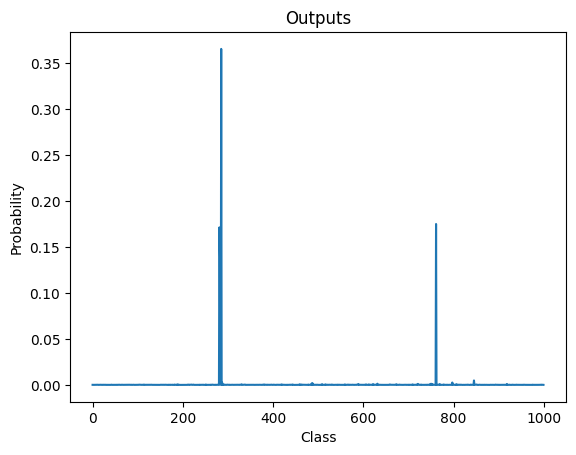

In [17]:
# Class to generate graph from tensors (display probability distribution of output logits)
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

def softmax(vector):
  if torch.cuda.is_available():
    return F.softmax(vector, dim=1)
  else:
    x = vector
    x_max = np.max(x, axis=1, keepdims=True)
    e_x = np.exp(x - x_max)
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def softmaxed(vector):
  if torch.cuda.is_available():
    return (torch.sum(vector) == 1).item() and (vector >= 0).all().item() and (vector <= 1).all().item()
  else:
    return (np.sum(vector) == 1) and (vector >= 0).all() and (vector <= 1).all()

def plotOutput(vector):
  """
  Enables visualisation for output of Neural Network
  """
  if not softmaxed(vector):
    vector = softmax(vector) # Softmax function makes vector L1 normalised
  # Very basic error handling if GPU not available and vector is NumPy array vs Torch Tensor
  try:
    vec = vector.detach().cpu().numpy()
  except:
    vec = vector
  plt.plot(vec[0])
  plt.title("Outputs")
  plt.xlabel("Class")
  plt.ylabel("Probability")
  plt.show()

plotOutput(logits)


## Load Data with HuggingFace datasets

In [18]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("X-iZhang/CheXpert-plus-RRG", "findings_section")

README.md:   0%|          | 0.00/832 [00:00<?, ?B/s]

findings_section/valid-00000-of-00001.pa(…):   0%|          | 0.00/164M [00:00<?, ?B/s]

Generating valid split:   0%|          | 0/62 [00:00<?, ? examples/s]

In [19]:
print(ds)
print("Dataset object type:")
print(type(ds["valid"]))

DatasetDict({
    valid: Dataset({
        features: ['main_image', 'findings_section', 'default_prompt'],
        num_rows: 62
    })
})
Dataset object type:
<class 'datasets.arrow_dataset.Dataset'>


In [20]:
from PIL import Image
example = ds["valid"][0]
img = example["main_image"]

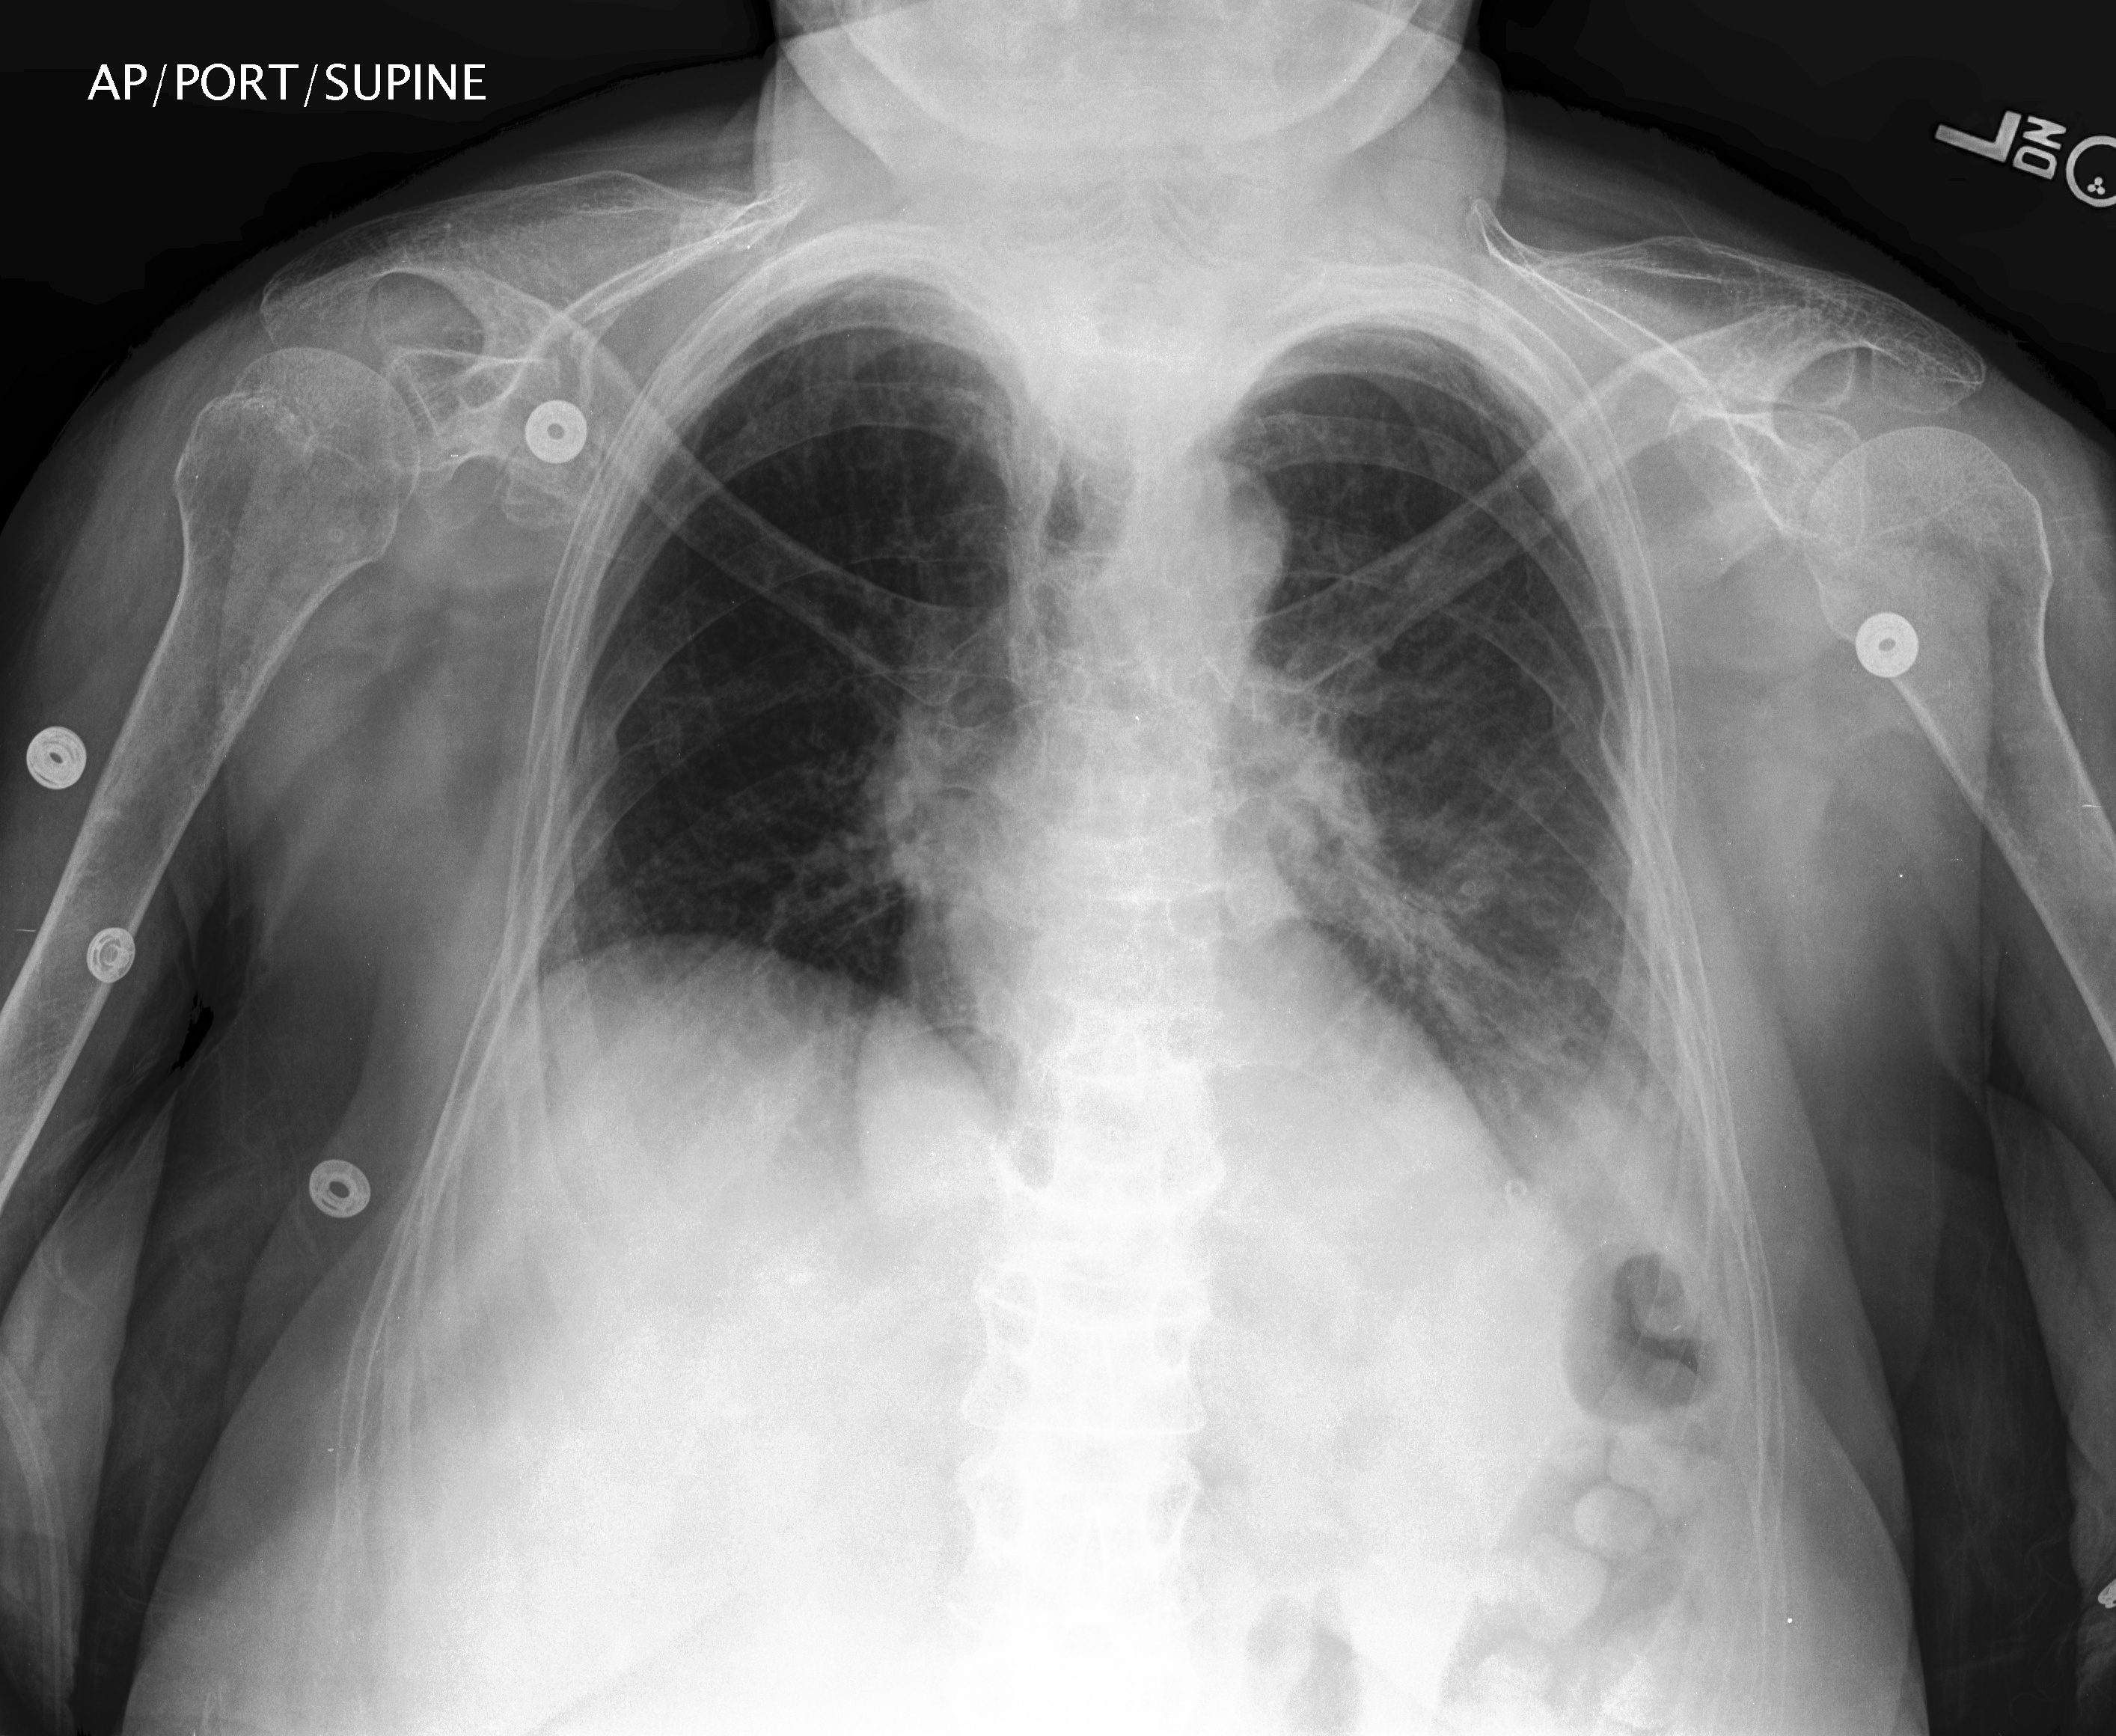

In [21]:
img